In [2]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from wordcloud import WordCloud, STOPWORDS
import pandas_profiling
import plotly.express as px




# Data Cleaning 

In [3]:
#import csv's
orders_df = pd.read_csv('orders.csv')
df = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])
departments_df = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')

In [4]:
# Checking nans
orders_df.isna().sum()

order_id                      0
user_id                       0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    12254
dtype: int64

In [5]:
nullscol = orders_df[orders_df.isna().any(axis=1)]
#nulls in days_since_prior_order are people who have just bought once in instacart
nullscol.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0    2425083    49125             1          2                 18   
1    1944304   162867             1          3                 17   
6    1378095    73110             1          6                 10   
12    763857   195070             1          5                  2   
46     49056    14451             1          1                 11   

    days_since_prior_order  
0                      NaN  
1                      NaN  
6                      NaN  
12                     NaN  
46                     NaN

In [6]:
orders_df.describe()

order_id       user_id   order_number      order_dow  \
count  2.000000e+05  200000.00000  200000.000000  200000.000000   
mean   1.710075e+06  103150.31640      17.144680       2.775845   
std    9.876437e+05   59603.83956      17.701549       2.044984   
min    1.000000e+01       2.00000       1.000000       0.000000   
25%    8.532758e+05   51541.00000       5.000000       1.000000   
50%    1.709227e+06  102829.00000      11.000000       3.000000   
75%    2.563077e+06  154731.50000      23.000000       5.000000   
max    3.421080e+06  206209.00000     100.000000       6.000000   

       order_hour_of_day  days_since_prior_order  
count      200000.000000           187746.000000  
mean           13.458635               10.999989  
std             4.220867                9.147087  
min             0.000000                0.000000  
25%            10.000000                4.000000  
50%            13.000000                7.000000  
75%            16.000000               15.000000  
max            23.000000               30.000000

# Orders
### Week, hour ...

In [7]:
# Import order dataset
orders_df.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   1944304   162867             1          3                 17   
2   1201011   147243            14          0                 16   
3   1906860   195275            81          1                 11   
4   2766469    58222             3          6                 11   

   days_since_prior_order  
0                     NaN  
1                     NaN  
2                     3.0  
3                     3.0  
4                     6.0

### Profilling

In [8]:
# profile_orders = orders_df.profile_report(title='Profiling Report Orders') 
# profile_orders

## Frequency of order by week day

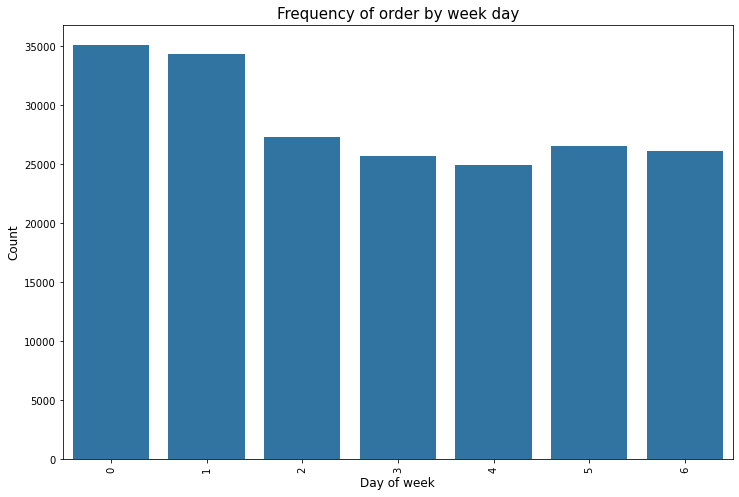

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

## Frequency of order by hour of the day

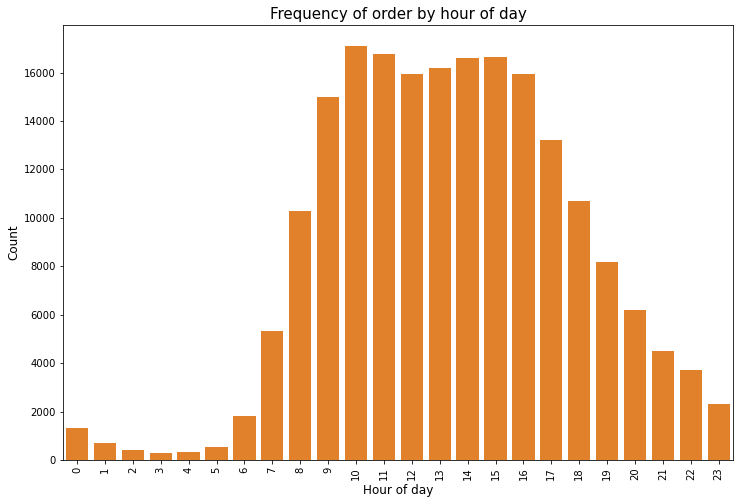

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

## Frequency day of the week vs hour of the day

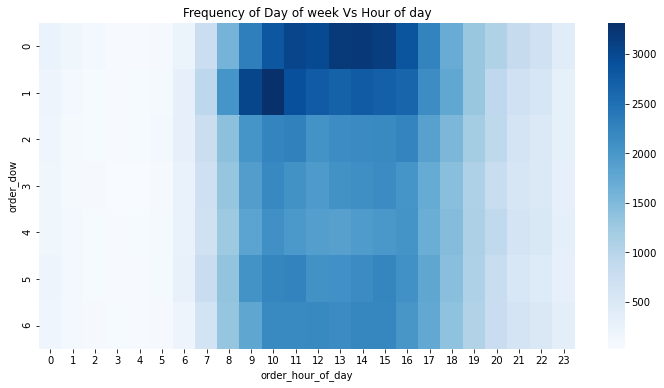

In [11]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="Blues")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

## Days since prior order

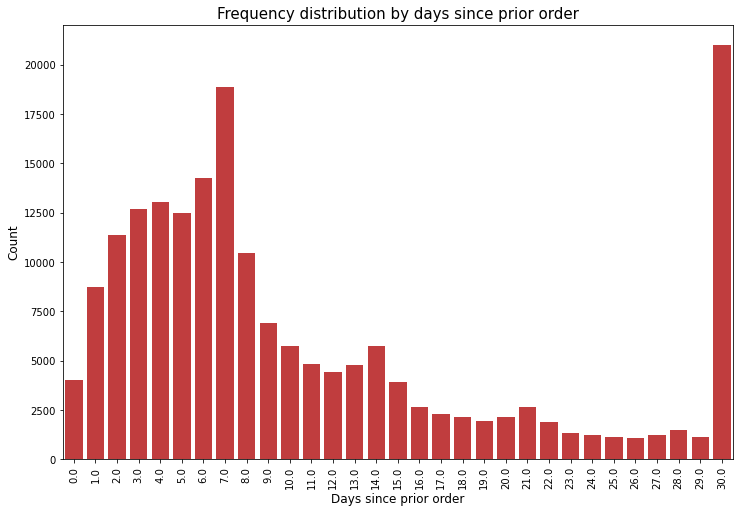

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

# Order products + products
### Merge

In [13]:
# order product dataset
df.head()

order_id  product_id
0        10          24
1        10          83
2        10          16
3        10          24
4        10          83

In [14]:
# product dataset 
products.head()

product_id  department_id                product_name
0          61             19               cookies cakes
1         104             13           spices seasonings
2          94              7                         tea
3          38              1                frozen meals
4           5             13  marinades meat preparation

In [15]:
# profile_products = products.profile_report(title='Profiling Report Orders') 
# profile_products

In [16]:
#products.product_name.unique().tolist() #There is one product name called missing

In [17]:
prodtest = products.loc[products['product_name']=='missing']
prodtest

product_id  department_id product_name
32         100             21      missing

### Merge df and products

In [18]:
# Merge product labels
df = pd.merge(df, products, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df.head()

order_id      product_name
0        10      fresh fruits
1        10  fresh vegetables
2        10       fresh herbs
3        10      fresh fruits
4        10  fresh vegetables

In [19]:
# profile_df = df.profile_report(title='Profiling Report Orders') 
# profile_df

# Outliers
### dropping 'missing' ( 0.2% of df)

In [20]:
# order_missing = df.loc[df['product_name']=='missing']
# order_missing

In [21]:
df = df[~df.product_name.str.contains("missing") == True]


## EDA - df (products+oders products)

In [22]:
# Get modes and unique values
df.astype(object).describe()

order_id  product_name
count    2014752       2014752
unique    199981           133
top       790903  fresh fruits
freq         137        226039

In [23]:
# Check product frequencies
df['product_name'].value_counts()

fresh fruits                  226039
fresh vegetables              212611
packaged vegetables fruits    109596
yogurt                         90751
packaged cheese                61502
                               ...  
kitchen supplies                 561
baby bath body care              515
baby accessories                 504
beauty                           387
frozen juice                     279
Name: product_name, Length: 133, dtype: int64

In [24]:
most_sold = df['product_name'].value_counts().head(10)
most_sold

fresh fruits                     226039
fresh vegetables                 212611
packaged vegetables fruits       109596
yogurt                            90751
packaged cheese                   61502
milk                              55150
water seltzer sparkling water     52564
chips pretzels                    45306
soy lactosefree                   39389
bread                             36381
Name: product_name, dtype: int64

## Most sold products

In [25]:
# plt.figure(figsize=(12,8))
# most_sold.plot(kind='bar')
# plt.title('Most sold products')

In [26]:
# y = df['product_name'].value_counts().head(40).to_frame()
# #y.index

In [27]:
# # plotting a tree map
# import squarify

# plt.rcParams['figure.figsize'] = (20, 20)
# color = plt.cm.cool(np.linspace(0, 1, 50))
# squarify.plot(sizes = y.values, label = y.index, alpha=.8, color = color)
# plt.title('Tree Map for Popular products')
# plt.axis('off')
# plt.show()

In [28]:
# comment_words = ''
# stopwords = set(STOPWORDS)
  
# # iterate through the csv file
# for val in df['product_name']:
      
#     # typecaste each val to string
#     val = str(val)
  
#     # split the value
#     tokens = val.split()
      
#     # Converts each token into lowercase
#     for i in range(len(tokens)):
#         tokens[i] = tokens[i].lower()
      
#     comment_words += " ".join(tokens)+" "
  
# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color ='white',
#                 colormap="Oranges_r",
#                 stopwords = stopwords,
#                 min_font_size = 10).generate(comment_words)
  
# # plot the WordCloud image                       
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
  
# plt.show()

### Most reordered products

In [29]:
#orderProductsTrain = pd.read_csv('order_products.csv')

In [30]:
# productsCount = orderProductsTrain["product_id"].value_counts().to_frame()
# productsCount["count"] = productsCount.product_id
# productsCount["product_id"] = productsCount.index
# mergedData = pd.merge(productsCount,products,how="left",on="product_id").sort_values(by="count",ascending=False)

In [31]:
# productsCountReordered = orderProductsTrain[orderProductsTrain["reordered"]==1]["product_id"].value_counts().to_frame()
# productsCountReordered["reordered_count"] = productsCountReordered.product_id
# productsCountReordered["product_id"] = productsCountReordered.index
# productCountReorderedMerged = pd.merge(productsCount,productsCountReordered,how="left",on="product_id").sort_values(by="count",ascending=False)
# productCountReorderedMerged["reordered_ratio"] = productCountReorderedMerged["reordered_count"]/productCountReorderedMerged["count"]
# productCountReorderedMerged.sort_values(by="reordered_ratio",ascending=False,inplace=True)
# productMerged = pd.merge(productCountReorderedMerged,products,how="left",on="product_id")

# fig,ax = plt.subplots()
# fig.set_size_inches(25,10)
# sns.barplot(data=productMerged[productMerged["count"]>20000].head(20),x="product_name",y="reordered_ratio",color="#34495e",ax=ax,orient="v")
# ax.set(xlabel='Product Names',ylabel="Count",title="Top Reordered Products")
# ax.set_ylim(0,1)
# plt.xticks(rotation=90)

# productMerged.head(10)

## Least reorded products

In [32]:

# fig,ax = plt.subplots()
# fig.set_size_inches(25,10)
# sns.barplot(data=productMerged[productMerged["count"]>10000].tail(20),x="product_name",y="reordered_ratio",color="#34495e",ax=ax,orient="v")
# ax.set(xlabel='Product Names',ylabel="Count",title="Low Reordered Products")
# ax.set_ylim(0,1)
# plt.xticks(rotation=90)

# productMerged.tail(10)

## Basket (0,1) - Products

In [33]:
df

order_id      product_name
0              10      fresh fruits
1              10  fresh vegetables
2              10       fresh herbs
3              10      fresh fruits
4              10  fresh vegetables
...           ...               ...
2019496   3420578       asian foods
2019497   3420578       fresh herbs
2019498   3420693     ice cream ice
2019499   3420693     ice cream ice
2019500   3420693     ice cream ice

[2014752 rows x 2 columns]

In [ ]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

In [ ]:
# Pivot the data - lines as orders and products as columns
pt_purchase = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

In [ ]:
pt_purchase["quantity_purchased"] = pt_purchase.sum(axis=1)


In [ ]:
pt_purchase

In [ ]:
pt_purchase['quantity_purchased'].describe()

### Quantity /basket

In [ ]:
cnt_srs = pt_purchase.quantity_purchased.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# Rules Definition

In [ ]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

In [ ]:
#frequent_itemsets.sort_values(by='support', ascending=False)

In [ ]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

## Convinience goods

In [ ]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))


In [ ]:
frequent_itemsets[(frequent_itemsets['length'] == 1) & (frequent_itemsets['support'] >= 0.15)].sort_values(by=['support'], ascending = False)

### Complementary

In [ ]:
# High Confidence and high Lift - complementary products
complementary = rulesConfidence[(rulesConfidence['confidence'] >= 0.5) & (rulesConfidence['lift'] >= 1.8)].sort_values(by=['lift'], ascending = False)
complementary[['antecedents','consequents','support','confidence','lift']]

### Substitute

In [ ]:
# Low Lift - Substitute products
subs = rulesConfidence[(rulesConfidence['lift'] < 1)].sort_values(by=['lift'], ascending = False)
subs[['antecedents','consequents','support','confidence','lift']]

In [ ]:
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET


# Department  Analysis

In [ ]:
# profile_dept = departments_df.profile_report(title='Profiling Report Orders') 
# profile_dept

### Data cleaning
Merging both datasets in order to see the department name instead of the product name

In [ ]:
df_dept = pd.merge(departments_df, products, how='left', on='department_id')


In [ ]:
#cleanning df_dept:
df_dept = df_dept[~df_dept.department.str.contains("missing") == True]


In [ ]:
df_department = pd.merge(df_dept, df, how='left', on='product_name')


## Cleanning

In [ ]:
df_department.drop(columns=['product_name', 'product_id','department_id'], inplace=True)


## Tree map

In [ ]:
z = df_department['department'].value_counts().to_frame()
z.index

In [ ]:
# plotting a tree map
import squarify

plt.rcParams['figure.figsize'] = (20, 20)
color = plt.cm.cool(np.linspace(0, 1, 50))
squarify.plot(sizes = z.values, label = z.index, alpha=.8, color = color)
plt.title('Tree Map for Popular departments')
plt.axis('off')
plt.show()

## Pivot the data

In [ ]:
# Pivot the data - lines as orders and products as columns
department_df = pd.pivot_table(df_department, index='order_id', columns='department', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
department_df.head()

In [ ]:
#department_df.describe()

### Number of departments per order

In [ ]:
nr_depts =department_df.sum(axis=1)
#nr_depts

In [ ]:
cnt_srs = nr_depts.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of departments in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Generate Frequent itemsets of departments

In [ ]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_depts = apriori(department_df, min_support=0.05, use_colnames=True)


In [ ]:
frequent_depts.sort_values(by='support', ascending=False).head()

In [ ]:
# Generate the association rules - by confidence
rulesConfidence_depts = association_rules(frequent_depts, metric="confidence", min_threshold=0.20)
rulesConfidence_depts.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence_depts.head()

In [ ]:
frequent_depts['length'] = frequent_depts['itemsets'].apply(lambda x: len(x))

# Length=1 and Support>=0.3
frequent_depts[(frequent_depts['length'] == 1) & (frequent_depts['support'] >= 0.3)].sort_values(by='support', ascending=False)

### Complementary Departments

In [ ]:
# High Confidence and high Lift
compl_dept = rulesConfidence_depts[(rulesConfidence_depts['confidence'] >= 0.5) & (rulesConfidence_depts['lift'] >= 1.9)].sort_values(by=['lift'], ascending = False)
compl_dept[['antecedents','consequents','support','confidence','lift']]

### Substitute Departments

In [ ]:
# low Lift - substitute products
subs_dept = rulesConfidence_depts[(rulesConfidence_depts['confidence'] >= 0.5) & (rulesConfidence_depts['lift'] < 1)].sort_values(by=['lift'], ascending = False)
subs_dept[['antecedents','consequents','support','confidence','lift']]

## Network View

In [ ]:
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence_depts.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()
#fig.savefig('figure.svg')
# TRY TO PLOT THE DIRECTION OF SOURCE -> TARGET
